# Regularized Regression: L$_1$ and L$_2$
#### by Elizabeth Barnes

Avoiding overfitting with regularization.

In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.io as io
import copy as copy
import csv

import datetime
import pandas as pd
import xarray as xr

#.............................................
# PLOTTING COMMANDS
#.............................................
import matplotlib as mpl
import cartopy as ct

# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

## Example: when $L_1$ makes sense

$L_1$ regularization (or LASSO) adds a term to the loss function that is proportional to the sum of the absolute value of the regression coefficients:

$\lambda \sum_i^N |\beta_i|$

This term acts to force small coefficients to *exactly* zero, and allowing only a few to stay large. $\lambda$ (or $\alpha$ as it is specified below), sets how important this term is. 

Let's look at example of when this may be useful by doing some regression with hourly data from Christmas Field.

In [2]:
filename = 'data/christman_2016.csv'
data_input = np.genfromtxt(filename, delimiter = ',')

# grab the variables I want
# grab_indices = [2,3,5,9,10,11] 
grab_indices = [4,2,5,9,10,11] 

data = data_input[:,grab_indices]

names_input = ['date','time','temp (F)', 'RH (%)', 'DewPt (F)','Wind (mph)', 'Dir (deg.)', 'Gust (mph)', 'Gust Dir (deg.)','Pres (mb)', 'Solar (W/m^2)','Precip (in)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
names[names.index('Precip (in)')] = 'Precip (mm)'

print(np.shape(data))
print(names)

(8784, 6)
['DewPt (F)', 'temp (F)', 'Wind (mph)', 'Pres (mb)', 'Solar (W/m^2)', 'Precip (mm)']


Since all of the units are different, we will standardize everything here. 

In [3]:
# standardize the data
data_std = preprocessing.scale(data)

print(data_std.mean(axis=0))
print(data_std.std(axis=0))

[ 5.17699625e-17  2.58849813e-16 -6.47124532e-18 -1.65081468e-14
 -8.08905665e-17 -1.45603020e-17]
[1. 1. 1. 1. 1. 1.]


Next we set our predictors and predictands.

In [4]:
# predict Dewpoint
y = data_std[:,0]

# define predictors (all 5 other variables)
x = data_std[:,1:]

Okay - let's fit the line and look how different forms of regularization impact the solution. Remember that $\alpha$ determines how important the regularization term is when computing the loss function. Make it big, and regularization becomes very important. Make $\alpha=0$ and you are back to standard OLS regression.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

print(np.shape(X_train))
print(np.shape(X_test))

(6148, 5)
(2636, 5)


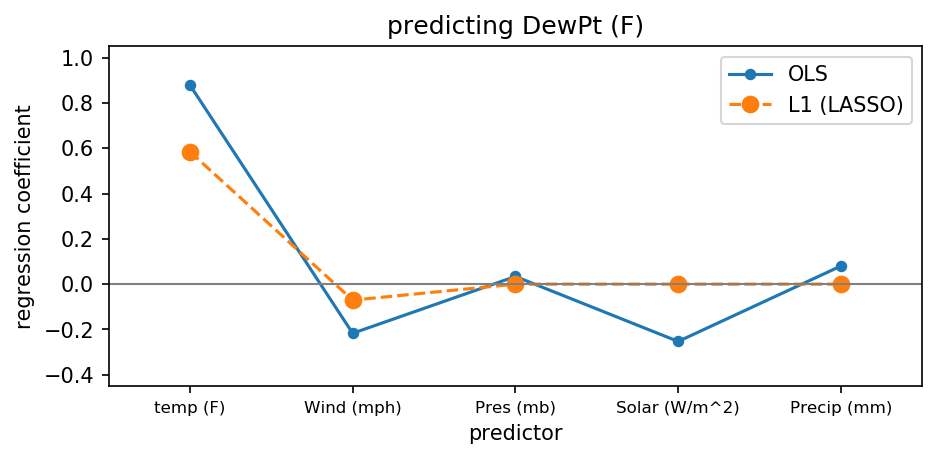

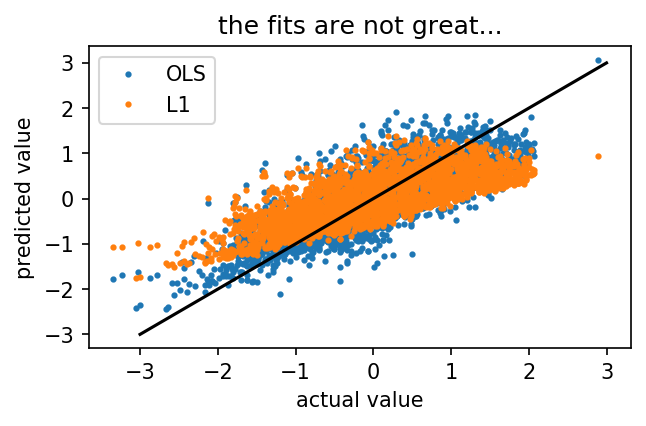

In [6]:
#--------------------------------------
# Regression Fitting
regOLS = linear_model.LinearRegression(normalize=False, fit_intercept=True)
regL1 = linear_model.Lasso(alpha=.15,normalize=False, fit_intercept=True)
regL2 = linear_model.Ridge(alpha=2000,normalize=False, fit_intercept=True)

regOLS.fit(X_train,y_train)
regL1.fit(X_train,y_train)
regL2.fit(X_train,y_train)

predictOLS = regOLS.predict(X_test)
predictL1 = regL1.predict(X_test)
predictL2 = regL2.predict(X_test)
#--------------------------------------

MS = 4

plt.figure(figsize=(7,3))
plt.plot(regOLS.coef_,'.-', markersize=9, label='OLS')
plt.plot(regL1.coef_,'.--', markersize=15, label='L1 (LASSO)')
# plt.plot(regL2.coef_,'.--', markersize=9, label='L2 (Ridge)')
plt.xticks(np.arange(0,6), labels=names[1:], fontsize=8)
plt.xlabel('predictor')
plt.ylabel('regression coefficient')
plt.axhline(y=0,color='gray', linewidth=1)
plt.legend()
plt.xlim(-.5,4.5)
plt.ylim(-.45,1.05)
plt.title('predicting ' + names[0])
plt.show()

plt.figure(figsize=(7/1.5,4/1.5))
plt.title('the fits are not great...')
plt.plot(y_test,predictOLS, '.', markersize=MS, label='OLS')
plt.plot(y_test,predictL1, '.', markersize=MS, label='L1')
# plt.plot(y_test,predictL2, '.', markersize=MS, label='L2')
plt.plot((-3,3),(-3,3),'-k')
plt.ylabel('predicted value')
plt.xlabel('actual value')
plt.legend()
plt.show()


Fun! LASSO regularization helps us determine which variables are the *most* important, and helps us to avoid overfitting. It sets small coefficients to zero.

## Example: when Ridge ($L_2$) makes sense

While LASSO helps set small coefficients to zero, Ridge regression (or $L_2$ regularization) helps spread/share the weights across all of the regression coefficients. The term added to the loss function is:

$\lambda \sum_i^N \beta_i^2$

$\lambda$ (or $\alpha$ as it is specified below), sets how important this term is. 

Let's look at example of when this may be useful by doing some regression with daily Z500 data across the globe.


In [2]:
DATA = io.loadmat('data/z500_daily.mat')    
Xall = np.array(DATA['X'])
LAT = np.array(DATA['LAT'])[0,:]
LON = np.array(DATA['LONG'])[0,:]
TIME = np.array(DATA['TIME'])
print('data is loaded')

# less data to deal with
X = copy.deepcopy(Xall[:,::4,::4])
LAT = LAT[::4]
LON = LON[::4]

del Xall

data is loaded


In [3]:
# get time vector in order for xarray
dateList = []
for i, junk in enumerate(TIME[:,0]):
    dateList.append(datetime.datetime(int(TIME[i,1]),int(TIME[i,2]),int(TIME[i,3])))
    

In [4]:
# create xarray 
da = xr.DataArray(X,dims=('time','latitude','longitude'),coords={'latitude': LAT, 'longitude': LON, 'time': dateList}, name='z500')

In [5]:
climatology_mean = da.groupby("time.month").mean("time")
climatology_std = da.groupby("time.month").std("time")
anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    da.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

X = da.where(anomalies['time.season'] == 'DJF',drop=True)
print(np.shape(X))

(3038, 16, 30)


In [49]:
# Define the predictand point
predictLatIndex = 9
predictLonIndex = 0
y = np.squeeze(X[:,predictLatIndex,predictLonIndex])
print(np.shape(y))

(3038,)


In [50]:
# Define the predictors
# grab only the other half of the globe to predict the point
x = copy.deepcopy(X)
x[:,:,0:6] = 0.
x[:,:,26:] = 0.

x = np.reshape(x.values,(np.shape(x)[0],np.shape(x)[1]*np.shape(x)[2]))
print(x.shape)

(3038, 480)


The above code sets the values near the predictand (y) to zero so that they cannot be used in the regression. That is, anything close to the same longitude as the predictand cannot be used. You will notice this when you plot the regression coefficients on a map, and they are colored gray.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


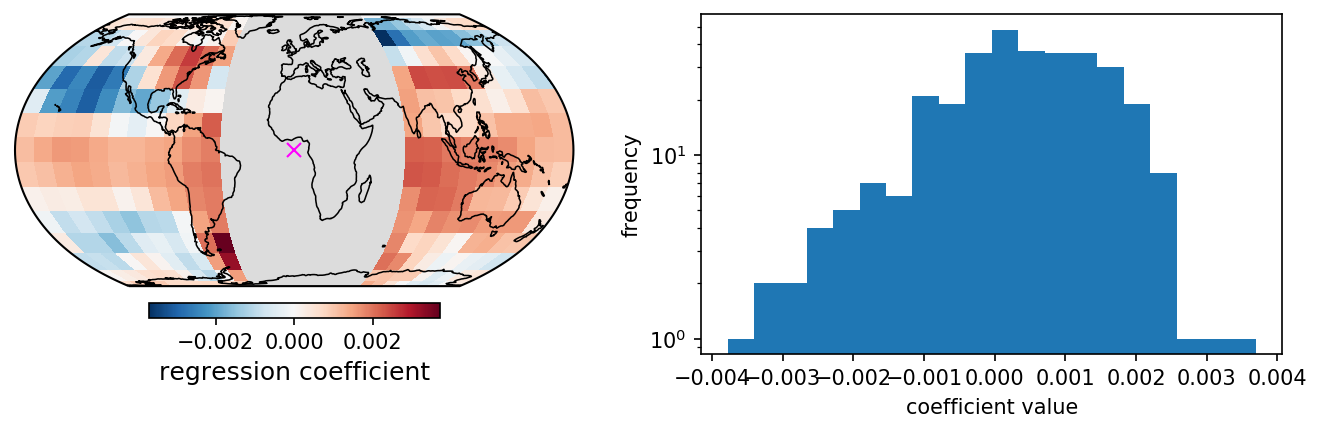

In [65]:
#--------------------------------------
# Regression Fitting
# reg = linear_model.LinearRegression()
# reg = linear_model.Lasso(alpha=200.)
reg = linear_model.Ridge(alpha=1e8)

reg.fit(x,y)
#--------------------------------------

# set unused coefficients to nan for plotting
data = np.reshape(reg.coef_,(len(da['latitude'].values),len(da['longitude'].values)))
data[:,0:6] = np.nan
data[:,26:] = np.nan

# get rid of line at long = 0.0
data_cyc = np.append(data,data[:,0:1],axis=1)
lons_cyc = np.append(da['longitude'].values,360.)

# plot the figure of regression coefficients
data_crs = ct.crs.PlateCarree()
plt.figure(figsize=(11,3))
ax = plt.subplot(1,2,1,projection=ct.crs.EqualEarth())
ax.set_global()
ax.coastlines(linewidth = .75)
ax.background_patch.set_facecolor('gainsboro')

maxval = np.nanmax(reg.coef_[:])
image = ax.pcolor(lons_cyc, da['latitude'].values, data_cyc, transform=data_crs, cmap='RdBu_r', vmin=-maxval, vmax = maxval)
image.set_clim(-maxval,maxval)
cb = plt.colorbar(image, shrink=.5, orientation="horizontal", pad=.05)
cb.set_label('regression coefficient', fontsize=12)

plt.plot(da['latitude'].values[predictLatIndex],da['longitude'].values[predictLonIndex],'x',markersize=7, linewidth=10, color = 'fuchsia')

plt.subplot(1,2,2)
plt.hist(reg.coef_[:],20)
plt.yscale('log')
plt.xlabel('coefficient value')
plt.ylabel('frequency')
plt.show()

I love ridge regression since I do a lot of research with *maps*. $L_2$ regularization helps the weight get spread across predictors - thus often taking into account the correlations across predictors I know are there.